Necessary imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2

Using TensorFlow backend.


In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, BatchNormalization, Add, Activation, AveragePooling2D, Dropout, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.losses import categorical_crossentropy

Method to load datasets based on their name. This method can load one of the three datasets namely, MNIST, Fashion_MNIST and Cifar-10.

In [0]:
def load_dataset(dataset):
  if dataset == 'mnist':
    return tf.keras.datasets.mnist.load_data()
  elif dataset == 'fashion_mnist':
    return tf.keras.datasets.fashion_mnist.load_data()
  elif dataset == 'cifar-10':
    return tf.keras.datasets.cifar10.load_data()
  else:
    return -1

This method preprocesses the dataset. It increases the size of the image to 64x64 and normalises the dataset by mean subtraction. The labels are converted to one hot representation. 

In [0]:
def preprocess_dataset(x_train, y_train, x_test, y_test):
  # expand the dimension (add the channel axis to MNIST and Fashion_MNIST)
  if len(x_train.shape) == 3 :
    x_train = tf.expand_dims(x_train, -1)
    x_test = tf.expand_dims(x_test, -1)

  # resize the image
  x_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((64,64))) for im in x_train])
  x_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((64,64))) for im in x_test])

  # Convert the labels to their one-hot representation
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)

  # Normalise the dataset by mean subtraction
  x_train = x_train.astype('float32')
  x_test = x_test.astype('float32')
  x_train_mean = np.mean(x_train, axis=0)
  x_train -= x_train_mean
  x_test -= x_train_mean

  return x_train, y_train, x_test, y_test

This method is used to visualize the first 4 fail cases and success cases  of the prediction.

In [0]:
def visualize(pred_labels, test_labels, test_images, dataset_name):
  # list to store the index of the success cases and fail cases
  success_cases = []
  fail_cases = []
  for i in range(len(test_labels)):
    if test_labels[i].argmax() == pred_labels[i].argmax() and len(success_cases)<5:
      success_cases.append(i)
    elif test_labels[i].argmax() != pred_labels[i].argmax() and len(fail_cases)<5:
      fail_cases.append(i)
    if len(success_cases) == 4 and len(fail_cases) == 4:
      break
  
  # cmap = gray from MNIST and fashion_mnist
  if len(test_images[0].shape) == 2:
    cmap = 'gray'
  else:
    cmap = None
  
  # plotting the success cases
  fig, ax = plt.subplots(nrows=2, ncols=2)
  for row in ax:
    for col in row:
        col.imshow(test_images[success_cases.pop(0)], interpolation='nearest', cmap=cmap)
  fig.suptitle('Success Cases of resnet34 on ' + dataset_name)

  # plotting the fail cases
  plt.show()
  fig, ax = plt.subplots(nrows=2, ncols=2)
  for row in ax:
    for col in row:
        col.imshow(test_images[fail_cases.pop(0)], interpolation='nearest', cmap=cmap)
  fig.suptitle('Fail Cases of resnet34 on ' + dataset_name)
  plt.show()

This method return the resnet34 model. It is based on the architecture proposed in the original paper with some improvements.

In [0]:
def identity_block(x, f, dropout_rate):
  x_skip = x
  x = Conv2D(filters=f,kernel_size=(3,3),strides=(1, 1),padding="same", kernel_initializer=tf.initializers.GlorotUniform(),kernel_regularizer=l2(1e-4))(x)
  x = Dropout(dropout_rate)(x)
  x = BatchNormalization(axis=3)(x)
  # x = Activation('relu')(x)
  x = LeakyReLU()(x)
  x = Conv2D(filters=f,kernel_size=(3,3),strides=(1, 1),padding="same", kernel_initializer=tf.initializers.GlorotUniform(),kernel_regularizer=l2(1e-4))(x)
  x = Dropout(dropout_rate)(x)
  x = BatchNormalization(axis=3)(x)
  x = Add()([x, x_skip])
  # x = Activation('relu')(x)
  x = LeakyReLU()(x)
  return x

def conv_block(x, f, dropout_rate):
  x_skip = x
  x = Conv2D(filters=f,kernel_size=(3,3),strides=(2, 2),padding="same", kernel_initializer=tf.initializers.GlorotUniform(),kernel_regularizer=l2(1e-4))(x)
  x = Dropout(dropout_rate)(x)
  x = BatchNormalization(axis=3)(x)
  # x = Activation('relu')(x)
  x = LeakyReLU()(x)
  x = Conv2D(filters=f,kernel_size=(3,3),strides=(1, 1),padding="same", kernel_initializer=tf.initializers.GlorotUniform(),kernel_regularizer=l2(1e-4))(x)
  x = Dropout(dropout_rate)(x)
  x = BatchNormalization(axis=3)(x)
  x_skip = Conv2D(filters=f,kernel_size=(1,1),strides=(2, 2),padding="same", kernel_initializer=tf.initializers.GlorotUniform(),kernel_regularizer=l2(1e-4))(x_skip)
  x = Dropout(dropout_rate)(x)
  x_skip = BatchNormalization(axis=3)(x_skip)
  x = Add()([x, x_skip])
  # x = Activation('relu')(x)
  x = LeakyReLU()(x)
  return x

def model_resnet34(image_shape, num_category):
  filters = [64, 128, 256, 512]
  blocks = [3, 4, 6, 3]
  dropout_rate = 0.2
  inputs = Input(shape=image_shape)
  x = Conv2D(filters=64,kernel_size=(7,7),strides=(2, 2),padding="same",kernel_initializer=tf.initializers.GlorotUniform(),kernel_regularizer=l2(1e-4))(inputs)
  x = Dropout(dropout_rate)(x)
  x = BatchNormalization(axis=3)(x)
  # x = Activation('relu')(x)
  x = LeakyReLU()(x)
  x = MaxPooling2D((3, 3), strides=(2, 2), padding="same")(x)

  first_block = True
  for b in blocks:
    f = filters.pop(0)
    x = identity_block(x, f, dropout_rate) if first_block == True else conv_block(x, f, dropout_rate)
    first_block = False
    for _ in range(b-1):
      x = identity_block(x, f, dropout_rate)

  x = AveragePooling2D(pool_size=(2,2))(x)
  x= Flatten()(x)
  outputs = Dense(units=num_category, activation='softmax', kernel_initializer=tf.initializers.GlorotUniform())(x)
  model = Model(inputs=inputs, outputs=outputs)
  
  return model

Load the dataset from the following options: 'mnist', 'fashion_mnist' and 'cifar-10'

In [7]:
dataset_name = 'mnist'
(train_img, train_lbl), (test_img, test_lbl) = load_dataset(dataset_name)

11493376/11490434 [==============================] - 0s 0us/step


Preprocess the dataset and get the train_images, train_labels, test_images and test_labels. 

In [0]:
train_images, train_labels, test_images, test_labels = preprocess_dataset(train_img, train_lbl, test_img, test_lbl)

Augment data for training if augment_data is set to True. 

In [0]:
augment_data = True
batch_size = 128
validation_percent = 0.1
epochs = 100
if augment_data:
  datagen = ImageDataGenerator(
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True,
      rotation_range=0,
      fill_mode='nearest',
      validation_split=validation_percent
  )
  train_iterator = datagen.flow(train_images, train_labels, batch_size=batch_size, subset='training')
  validation_iterator = datagen.flow(train_images, train_labels, batch_size=batch_size, subset='validation')

Create the model. Using adam optimiser (instead of the original SGD optimiser) with categorical_crossentropy as loss function for multiclass classification.

In [10]:
resnet34 = model_resnet34(image_shape = train_images[0].shape, num_category = len(train_labels[0]))
resnet34.compile(optimizer='adam', loss="categorical_crossentropy", metrics=['accuracy'])
resnet34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 64)   3200        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 32, 32, 64)   0           conv2d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 64)   256         dropout[0][0]                    
______________________________________________________________________________________________

Train the model with two callbacks. One of the callback is for reducing the learning rate when the val_loss starts to plateau. The other callback is for stopping early if the val_loss doesn't change over a few epochs. The early stopping callback restores the best weights found. 

In [11]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=3, min_lr=0.5e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=15, verbose=1, restore_best_weights=True)
if augment_data:
  history = resnet34.fit(train_iterator, epochs=epochs, steps_per_epoch=len(train_iterator), 
                                validation_data=validation_iterator, validation_steps=len(validation_iterator), 
                                callbacks=[reduce_lr, early_stop])
else:
  history = resnet34.fit(x=train_images, y=train_labels, epochs=epochs, batch_size=batch_size, 
                      validation_split=validation_percent,
                      callbacks=[reduce_lr, early_stop])

Epoch 1/100
422/422 [==============================] - 45s 106ms/step - loss: 1.2185 - accuracy: 0.8615 - val_loss: 1.0813 - val_accuracy: 0.9080 - lr: 0.0010
Epoch 2/100
422/422 [==============================] - 43s 103ms/step - loss: 0.7254 - accuracy: 0.9539 - val_loss: 0.9198 - val_accuracy: 0.8842 - lr: 0.0010
Epoch 3/100
422/422 [==============================] - 43s 103ms/step - loss: 0.5183 - accuracy: 0.9645 - val_loss: 0.4853 - val_accuracy: 0.9543 - lr: 0.0010
Epoch 4/100
422/422 [==============================] - 43s 103ms/step - loss: 0.4019 - accuracy: 0.9680 - val_loss: 0.4046 - val_accuracy: 0.9578 - lr: 0.0010
Epoch 5/100
422/422 [==============================] - 43s 102ms/step - loss: 0.3364 - accuracy: 0.9694 - val_loss: 0.3713 - val_accuracy: 0.9475 - lr: 0.0010
Epoch 6/100
422/422 [==============================] - 44s 103ms/step - loss: 0.3059 - accuracy: 0.9697 - val_loss: 0.3406 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 7/100
422/422 [=========================

Plot the accuracy and loss graph over the epochs for training and validation. 

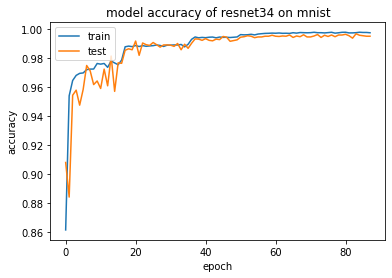

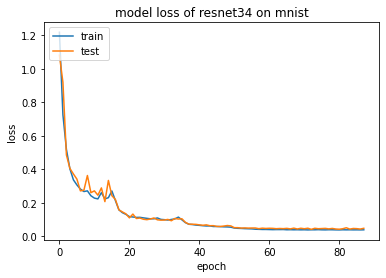

In [12]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy of resnet34 on ' + dataset_name)
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss of resnet34 on ' + dataset_name)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Evaluate the model performance on the test set.

In [13]:
eval = resnet34.evaluate(test_images, test_labels, batch_size=batch_size)

79/79 [==============================] - 2s 23ms/step - loss: 0.0453 - accuracy: 0.9958


Create predictions for the test set

In [0]:
predictions = resnet34.predict(test_images, batch_size=batch_size)

Visualize the some examples of the success and fail cases for the model on the test set.

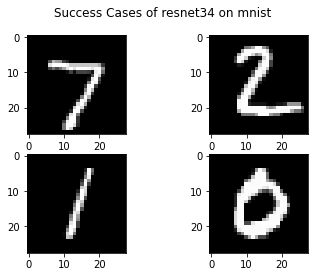

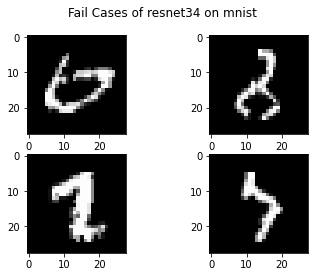

In [15]:
visualize(predictions, test_labels, test_img, dataset_name)